In [5]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import sys
sys.path.append("..")

import neuroprob as nprb
from neuroprob import utils


dev = nprb.inference.get_device()


import matplotlib.pyplot as plt
plt.style.use(['../../paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.7.1+cu101
Using device: cuda:0


### Synthetic heteroscedastic model

In [2]:
# Gaussian von Mises bump head direction model
track_samples = 4000
hd_t = np.empty(track_samples)
hd_t[0] = 0#np.pi
rn = np.random.randn(track_samples)
for k in range(1, track_samples):
    hd_t[k] = hd_t[k-1] + 0.1*rn[k]
    
hd_t = hd_t % (2*np.pi)

In [3]:
sample_bin = 0.05
neurons = 50

# Von Mises fields
angle_0 = np.linspace(0, 2*np.pi, neurons+1)[:-1]
beta = 0.3
rate_0 = np.random.rand(neurons)*5.0 + 1.0
w = np.stack([np.log(rate_0), beta*np.cos(angle_0), beta*np.sin(angle_0)]).T # beta, phi_0 for theta modulation
neurons = w.shape[0]

vm_rate = nprb.rate_models.vonMises_GLM(neurons, inv_link='exp')
vm_rate.set_params(sample_bin, w)



# Dispersion tuning curve
_angle_0 = np.random.permutation(angle_0)
_beta = (0.2*np.random.randn(neurons))**2 + 0.01
_rate_0 = np.random.rand(neurons)*500.0 + 500.0
w = np.stack([np.log(_rate_0), _beta*np.cos(_angle_0), _beta*np.sin(_angle_0)]).T # beta, phi_0 for theta modulation

vm_disp = nprb.rate_models.vonMises_GLM(neurons, inv_link='exp')
vm_disp.set_params(sample_bin, w)


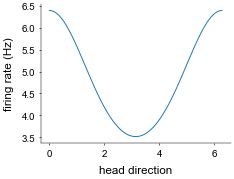

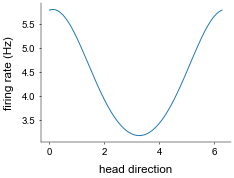

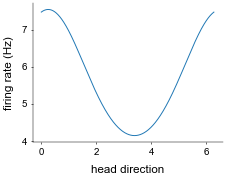

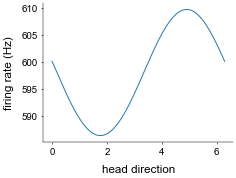

In [4]:
steps= 1000
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]

mean = vm_rate.eval_rate(covariates, show_neurons)
for k, neuron in enumerate(show_neurons):
    
    fig, ax = plt.subplots()
    line, = ax.plot(covariates[0], mean[0, k])
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')
    
plt.show()


steps= 1000
show_neurons = [0]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]

mean = vm_disp.eval_rate(covariates, show_neurons)
for k, neuron in enumerate(show_neurons):
    
    fig, ax = plt.subplots()
    line, = ax.plot(covariates[0], mean[0, k])
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')
    
plt.show()

In [5]:
# Count process output
#r_inv = 10.*np.ones(neurons)
#alpha = 0.2*np.ones(neurons)
likelihood = nprb.likelihoods.Poisson(sample_bin, neurons, 'exp')
#likelihood = nprb.likelihoods.Negative_binomial(sample_bin, neurons, 'exp', r_inv, dispersion_mapping=None)
#likelihood = nprb.likelihoods.ZI_Poisson(sample_bin, neurons, 'exp', alpha)

trials = 1
ll_samples = 10
in_dims = 1

XZ = torch.tensor(hd_t[None, :, None]).float() # MC, T, D
F_mu, F_var = vm_rate.compute_F(XZ) 
rate = likelihood.sample_rate(F_mu, F_var, trials, ll_samples) # MC, trials, neuron, time

rate = rate.mean(0).numpy()
#h = nprb.inference.sample_F(vm_rate, likelihood, [hd_t], 10, list(range(neurons)))
syn_train = likelihood.sample(rate, XZ=XZ)

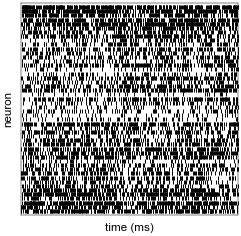

In [6]:
tr = 0
T = 1000

fig, ax = plt.subplots(figsize=(4,4))
utils.plot.raster_plot((fig, ax), syn_train[tr, :, :T], T, sample_bin*1000, neurons, markersize=10)
utils.plot.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

### Fitting SVGP

In [12]:
l = 10.*np.array([np.ones(1)])
v = np.ones(1)
kernels_tuples = [('variance', v), ('RBF', 'torus', l)]
VI_tuples = [(None, None, None, 1)]
ini_X = [hd_t]

In [17]:
cp = False

if cp is False:
    num_induc = 8
    inducing_points = np.linspace(0, 2*np.pi, num_induc+1)[None, :-1, None].repeat(neurons, axis=0)

    gpr = nprb.nonparametrics.Gaussian_process(
        in_dims, neurons, kernels_tuples, inducing_points=inducing_points, 
        inv_link='exp', whiten=True, jitter=1e-6, mean=np.zeros(neurons), learn_mean=True
    )

    gpd = nprb.nonparametrics.Gaussian_process(
        in_dims, neurons, kernels_tuples, inducing_points=inducing_points, 
        inv_link='exp', whiten=True, jitter=1e-6, mean=np.zeros(neurons), learn_mean=True
    )
    
    
    
else: # CP-SVGP 
    l = 1.*np.array([np.ones(neurons)])
    v = np.ones(neurons)
    #kernels_tuples = [('variance', v), ('RBF', 'torus', l)]
    K_list = [GP.kernels.Product(
        GP.kernels.Constant(variance=torch.tensor(v, dtype=torch.float)), 
        GP.kernels.RBF(input_dims=len(l), \
                       lengthscale=torch.tensor(l, dtype=torch.float), \
                       topology='torus'))
    ]

    track_dims_list = [[0]]
    kernel_TT = GP.kernels.KTT_kernel(K_list, track_dims_list)


    # inducing grid
    N_U = 100
    inducing_loc_list = [np.linspace(0, 2*np.pi, N_U+1)[None, None, :-1, None]]

    r_shape = (1,)
    nu_list = []
    Psi_list = []
    for u in inducing_loc_list:
        nu_list.append(np.zeros((neurons, *r_shape, u.shape[-2])))
        Psi_list.append(np.ones((neurons, u.shape[-2]))*0.1)

    #S_list = [np.eye(u.shape[-2])[None, ...].repeat(neurons, axis=0)]
    #S_type = GP.linalg.general_matrix
    k_V = 3
    S_list = [np.zeros((neurons, u.shape[-2]-1))]*k_V
    S_type = GP.linalg.trilI_Toeplitz_matrix


    # mapping
    gpr = nprb.nonparametrics.KCP_SVGP(
        in_dims, neurons, kernel_TT, inducing_loc_list, nu_list, Psi_list, S_list, S_type, 
        cheb_n=100, cheb_mc=1, GR_K=1, tr_mc=10, logdet_cheb=[True]*len(inducing_loc_list), jitter=1e-4, 
        nu_rshape_len=1, inv_link='exp', mean=np.zeros(neurons), learn_mean=True
    )

In [18]:
### inputs and likelihood ###
inputs = nprb.inference.input_group(in_dims, VI_tuples)
inputs.set_XZ(ini_X, track_samples, batch_size=1000, filter_len=1)  

likelihood = nprb.likelihoods.Poisson(sample_bin, neurons, 'exp')
#r_inv = 10.*np.ones(neurons)
#likelihood = nprb.likelihoods.Negative_binomial(sample_bin, neurons, 'exp', r_inv)
#alpha = .1*np.ones(neurons)
#likelihood = nprb.likelihoods.ZI_Poisson(sample_bin, neurons, 'exp', alpha, dispersion_mapping=None)
likelihood.set_Y(syn_train, batch_size=1000, filter_len=1) 


glm = nprb.inference.VI_optimized(inputs, gpr, likelihood)
glm.to(dev)

VI_optimized(
  (inputs): input_group()
  (mapping): Gaussian_process(
    (kernel): Product(
      (kern0): Constant()
      (kern1): RBF()
    )
  )
  (likelihood): Poisson()
)

In [19]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-3}

glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, bound='ELBO', ll_mode='MC')

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

KeyboardInterrupt: 

In [12]:
gpr.S[0].tensor_list[0].tensor

tensor([[[[-0.0727, -0.0680, -0.0653,  ...,  0.0042,  0.0044,  0.0008]],

         [[-0.0738, -0.0679, -0.0603,  ..., -0.0027, -0.0072, -0.0016]],

         [[-0.0634, -0.0586, -0.0547,  ..., -0.0028,  0.0006,  0.0022]],

         ...,

         [[-0.0731, -0.0663, -0.0600,  ...,  0.0016, -0.0018, -0.0079]],

         [[-0.0761, -0.0702, -0.0654,  ..., -0.0069, -0.0023, -0.0020]],

         [[-0.0694, -0.0637, -0.0627,  ..., -0.0122, -0.0100,  0.0016]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

In [13]:
gpr.Psi.tensor_list[0].tensor#_list[0]

tensor([[[[0.0990, 0.0990, 0.1010,  ..., 0.0990, 0.1010, 0.0990]],

         [[0.0990, 0.0990, 0.0990,  ..., 0.1010, 0.0990, 0.0990]],

         [[0.1010, 0.0990, 0.0990,  ..., 0.0990, 0.0990, 0.0990]],

         ...,

         [[0.0990, 0.1010, 0.1010,  ..., 0.1010, 0.1010, 0.1010]],

         [[0.0990, 0.0990, 0.1010,  ..., 0.0990, 0.0990, 0.1010]],

         [[0.1010, 0.0990, 0.1010,  ..., 0.1010, 0.1010, 0.0990]]]],
       device='cuda:0')

In [14]:
gpr.Psi_list[0].grad

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

### Inspect posterior

In [15]:
#print(glm.likelihood.alpha)

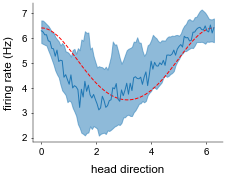

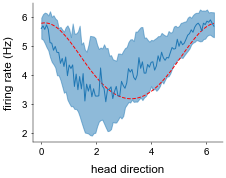

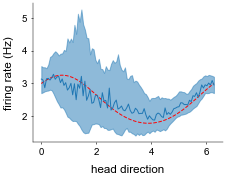

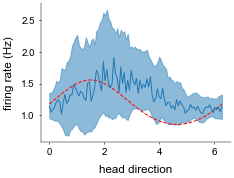

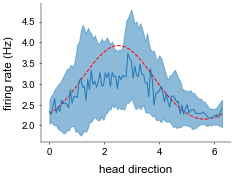

In [20]:
steps= 100
show_neurons = [0, 1, 6, 12, 20]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]

r_true = vm_rate.eval_rate(covariates, show_neurons)

lower, mean, upper = gpr.eval_rate(covariates, show_neurons, 'posterior', n_samp=10)
for k, neuron in enumerate(show_neurons):

    fig, ax = plt.subplots()
    ax.plot(covariates[0], r_true[0, k], 'r--')
    line, = ax.plot(covariates[0], mean[0, k])
    ax.fill_between(
        covariates[0], lower[0, k],
        upper[0, k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')

plt.show()

### Compute statistics

In [93]:
def get_field(glm_rate, grid_size, grid_shape, neuron):

    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = [x, y]
        return glm_rate.eval_rate(covariates, neuron).reshape(-1, *prevshape)

    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    return field


def compute_rate(glm_rate, neuron):
    grid_size = [50, 40]
    grid_shape = [[left_x, right_x], [bottom_y, top_y]]
    field = get_field(glm_rate, grid_size, grid_shape, neuron)
    return field

def compute_stats(glm, spktrain, behav_list): # statistics
    glm_rate = glm.rate_model[0]
    glm_lik = glm.likelihood
    
    bs = 5000
    T = 100000
    traj_len = 1
    N = int(np.ceil(T/bs))
    rate_model = []
    spktrain = spktrain[:T]

    for n in range(N):
        covariates_ = [b[n*bs:(n+1)*bs] for b in behav_list]
        rate_model += [glm_rate.eval_rate(covariates_, [0])[0]]

    rate_model = np.concatenate(rate_model)

    f_p = lambda c, avg, shape, t: stats.nb_count_prob(c, avg, shape, t)
    m_f = lambda x: x
    cnt_tuple = stats.count_KS_method(f_p, m_f, glm_rate.tbin.item(), spktrain, rate_model, \
                                      traj_len, shape=glm_lik.r_inv[0].item(), min_spikes=0)
    q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS, traj_lens = cnt_tuple

    return q_cdf, Z_DS, T_KS, s_KS

In [94]:
q_cdf, Z_DS, T_KS, s_KS = compute_stats(glm, rc_t[0], [rhd_t])

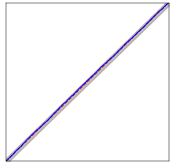

0.0095291454015618
-0.14628394160774894


In [95]:
fig = plt.figure(figsize=(3, 3))
ax = fig.subplots()
ax = stats.plot_dispersion(ax, q_cdf, s_KS)
plt.show()
print(T_KS)
print(Z_DS)